# Reddit Post Sentiment Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import sys
from PIL import Image
current_path = os.getcwd()
repos_substring = '/Reddit_Post_Pipeline'
repos_index = current_path.find(repos_substring)
project_folder_path = current_path[:repos_index + len(repos_substring)]
sys.path.append(project_folder_path)
from utilis.visualization_helper import *
from IPython.display import Image, display

from wordcloud import WordCloud #Word visualization
import matplotlib.pyplot as plt #Plotting properties
import seaborn as sns #Plotting properties

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer #Data transformation
from sklearn.model_selection import train_test_split #Data testing
from sklearn.linear_model import LogisticRegression #Prediction Model
from sklearn.metrics import accuracy_score #Comparison between real and predicted
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder #Variable encoding and decoding for XGBoost
import re #Regular expressions
import nltk
from nltk import word_tokenize
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/liuminghuang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Visualize data

In [2]:
news_output_csv_path = project_folder_path + '/output/posts_output.csv'
post_output_csv_path = project_folder_path + '/output/news_output.csv'
gpt_sentiment = gpt_sentiment_table(post_output_csv_path, news_output_csv_path)

In [3]:
gpt_sentiment

,post_id,date_generated,title,title_length,subjectivity_post,avg_polarity_news,polarity_post,post_sentiment_class
0,655026de54a7246a1e6f98371,2023-11-11,Join Talkie's AI Character Contest! 🎨 Prize Po...,83,0.000,0.07215,0.000,neutral
1,655026de54a7246a1e6f983710,2023-11-11,‘Motion Brush’ is new Runway Feature,36,0.455,0.07215,0.136,positive
2,655026de54a7246a1e6f98372,2023-11-11,"Weekly Self-Promotional Mega Thread 7, 06.11.2...",62,0.000,0.07215,0.000,neutral
3,655026de54a7246a1e6f98373,2023-11-11,Literal movie titles,20,0.000,0.07215,0.000,neutral
4,655026de54a7246a1e6f98374,2023-11-11,Did this hammered in the back of an Uber. I'm ...,78,0.300,0.07215,0.350,positive
...,...,...,...,...,...,...,...,...
776,657ba23f0e0a76252d8dfe735,2023-12-14,Teapots designed by various brands,34,0.500,-0.00360,0.000,neutral
777,657ba23f0e0a76252d8dfe736,2023-12-14,lol,3,0.700,-0.00360,0.800,very positive
778,657ba23f0e0a76252d8dfe737,2023-12-14,"ChatGPT Archive button, can't restore conversa...",51,0.000,-0.00360,0.000,neutral
779,657ba23f0e0a76252d8dfe738,2023-12-14,GPT absolutely cannot generate an image of a c...,66,0.389,-0.00360,0.022,positive


#### Joint Plot - Subjectivity vs Polarity

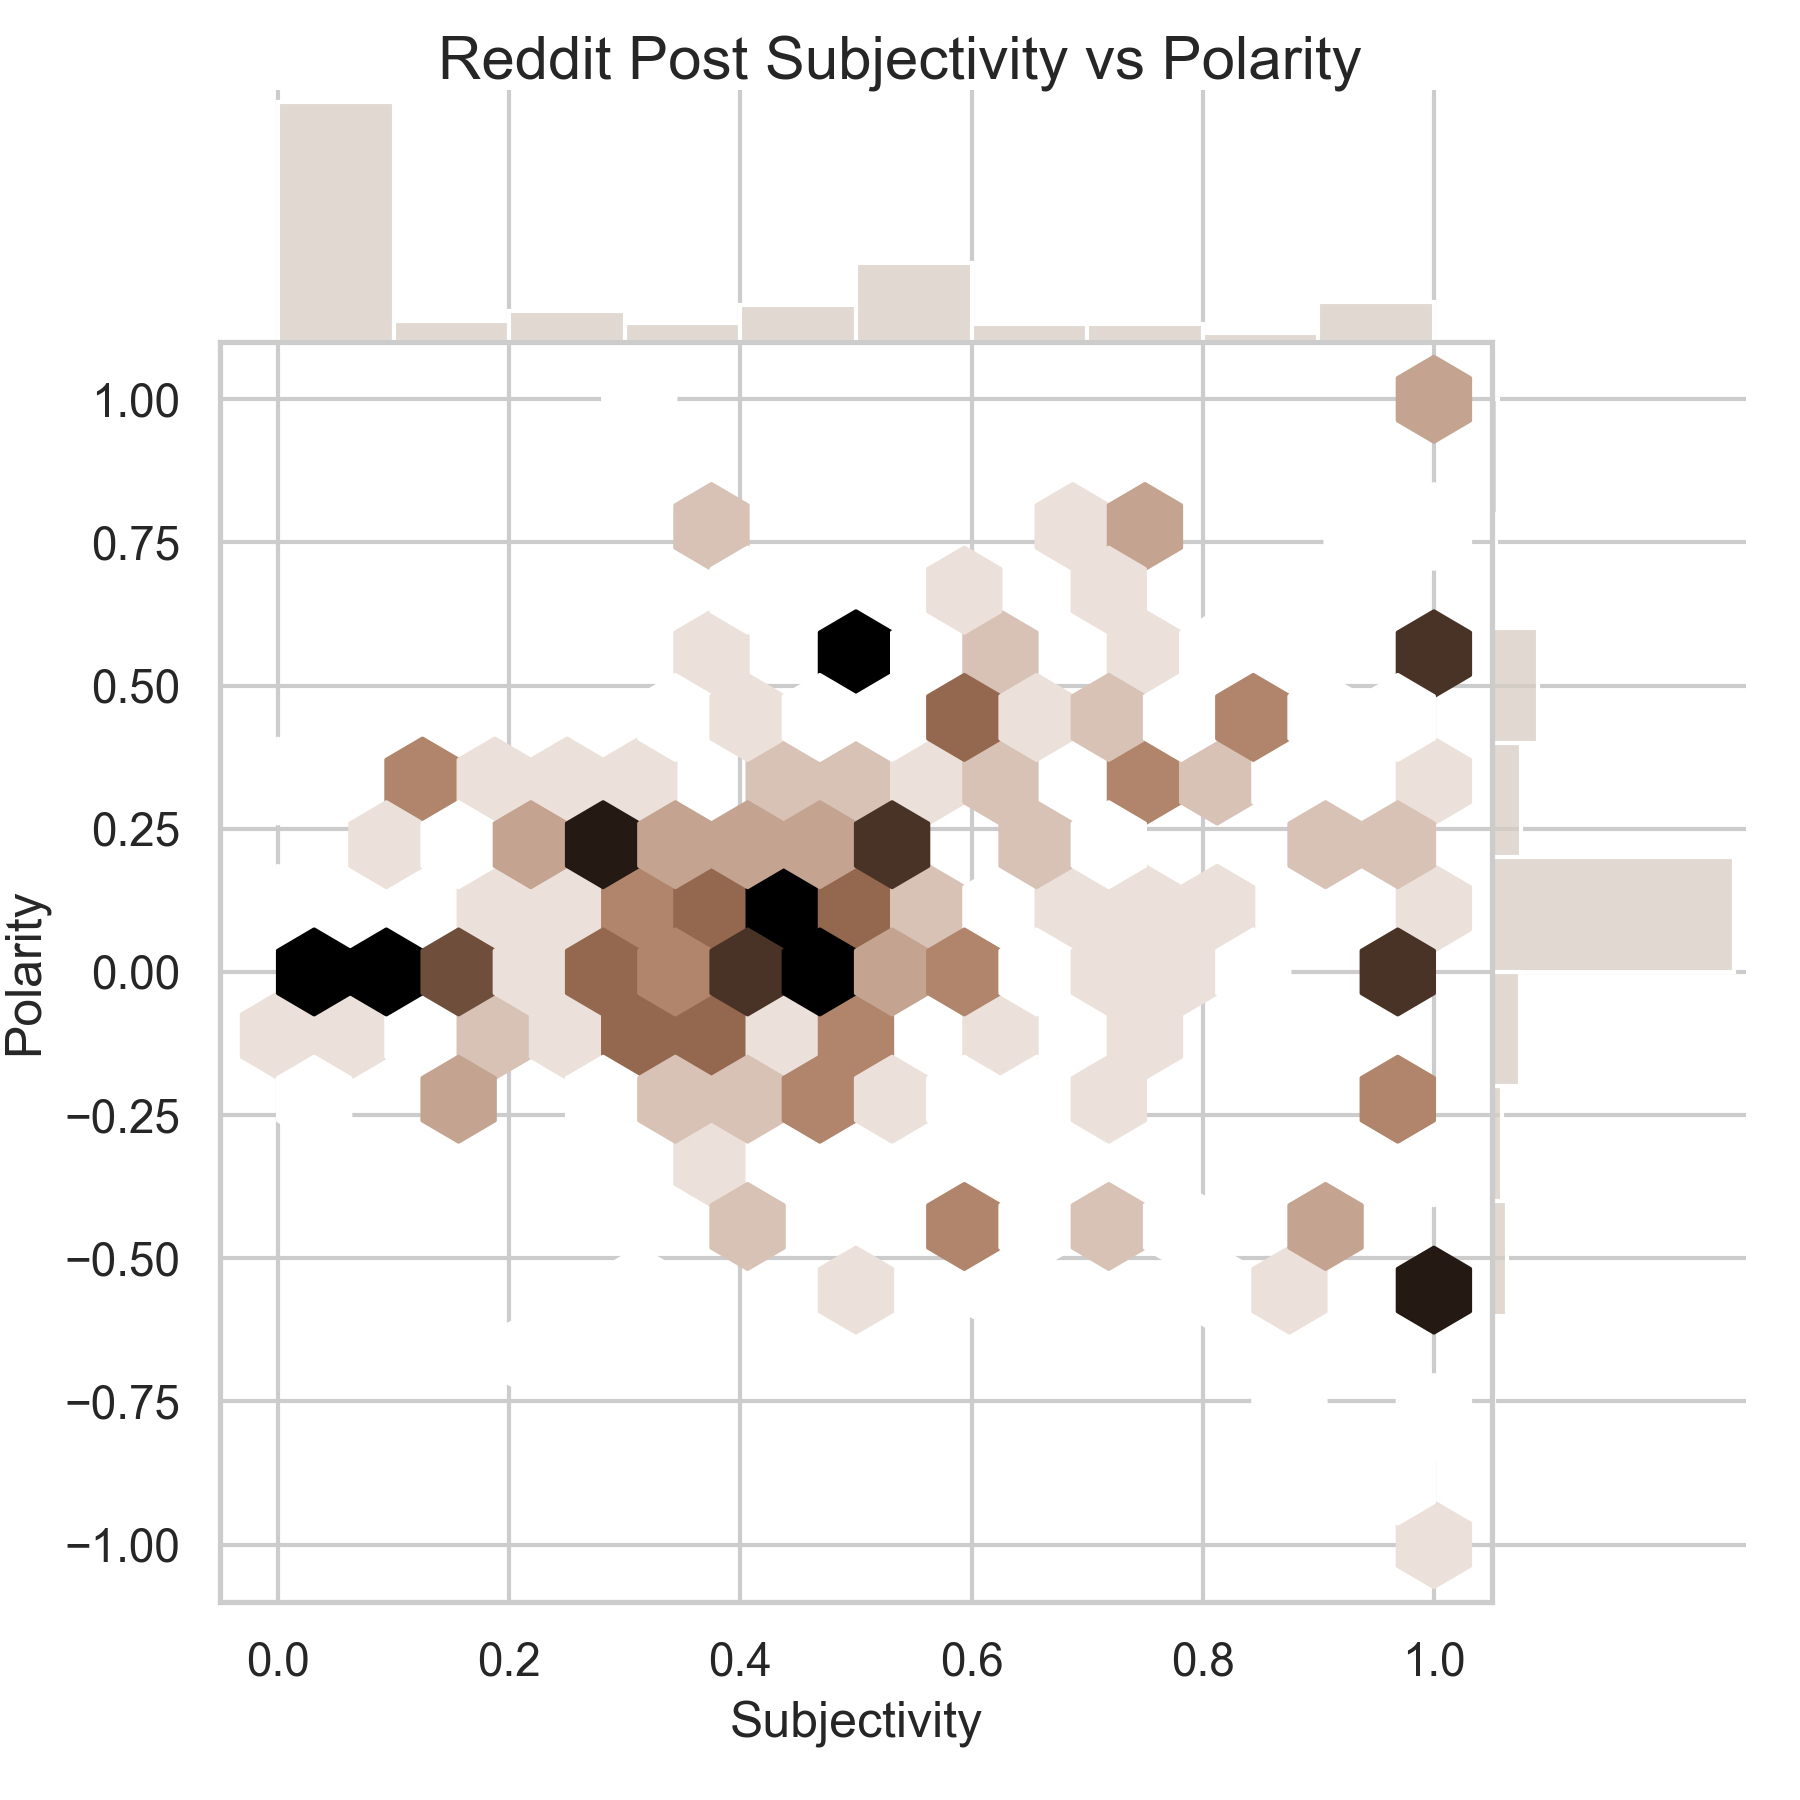

In [4]:
image_path = project_folder_path+ '/image/Subjectivity_vs_Polarity_joint_plot.png'
# Display the image in the Jupyter notebook
display(Image(filename=image_path))


#### Point Plot - News Polarity with Post Polarity

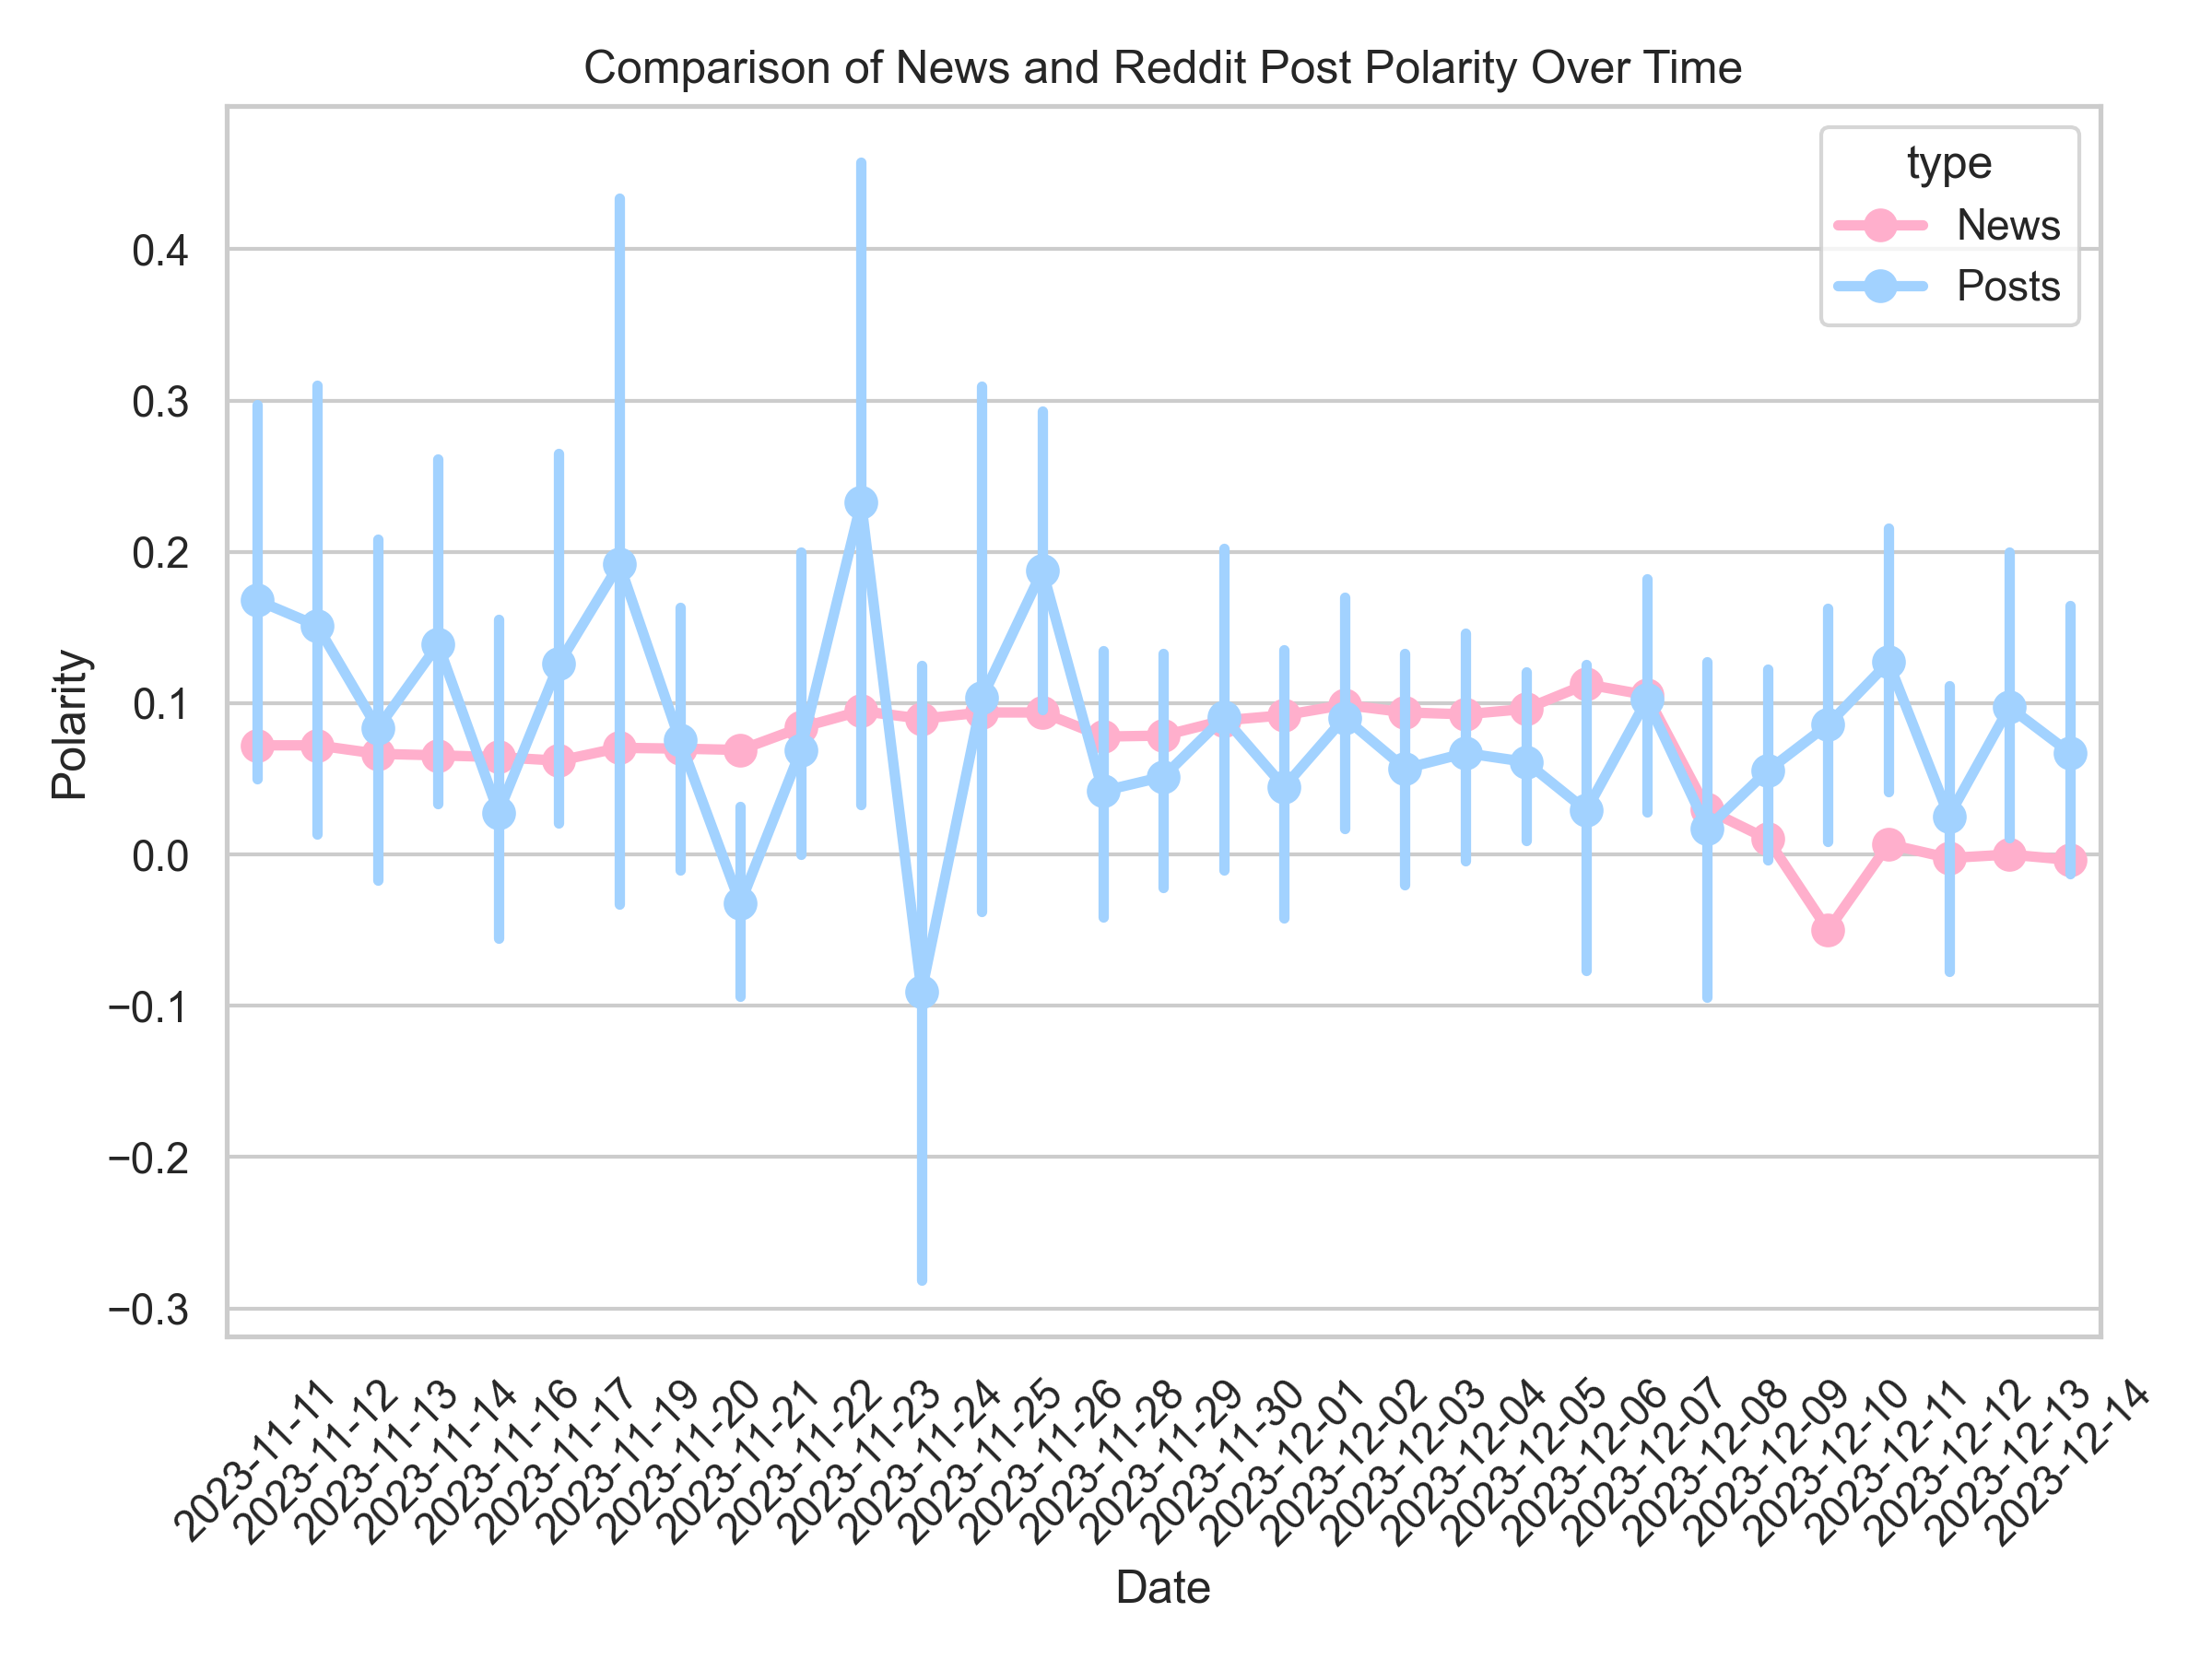

In [5]:
image_path = project_folder_path+ '/image/news_polarity_vs_post_polarity_point_plot.png'
# Display the image in the Jupyter notebook
display(Image(filename=image_path))


#### Box Plot - Distribution of Title Length

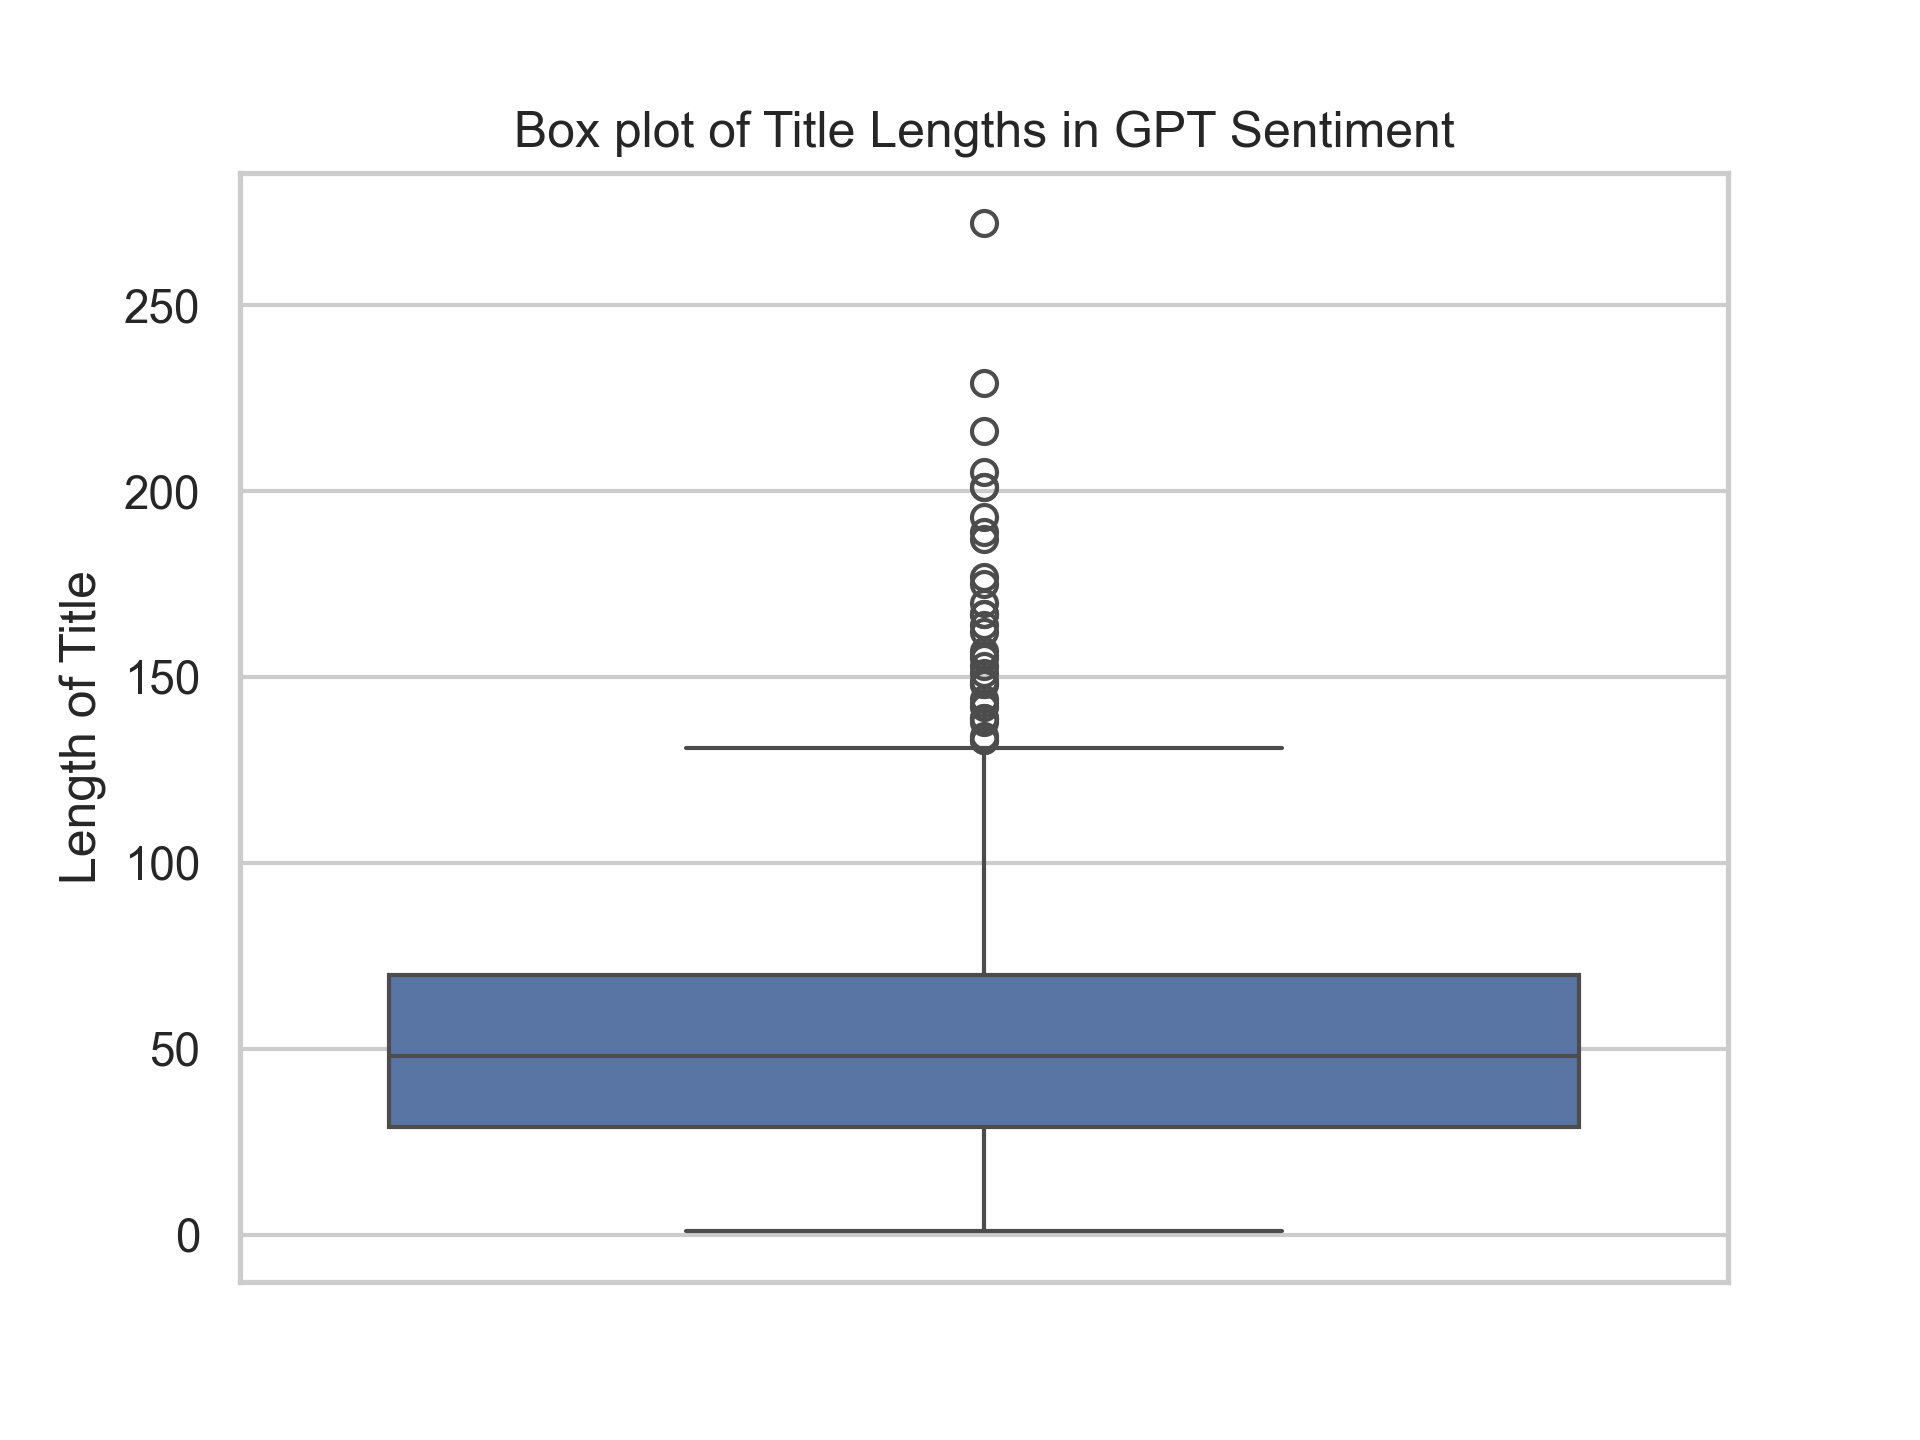

In [6]:
image_path = project_folder_path+ '/image/title_length_boxplot.png'
# Display the image in the Jupyter notebook
display(Image(filename=image_path))

#### Count Plot - Distribution of Each Post Sentiment Class

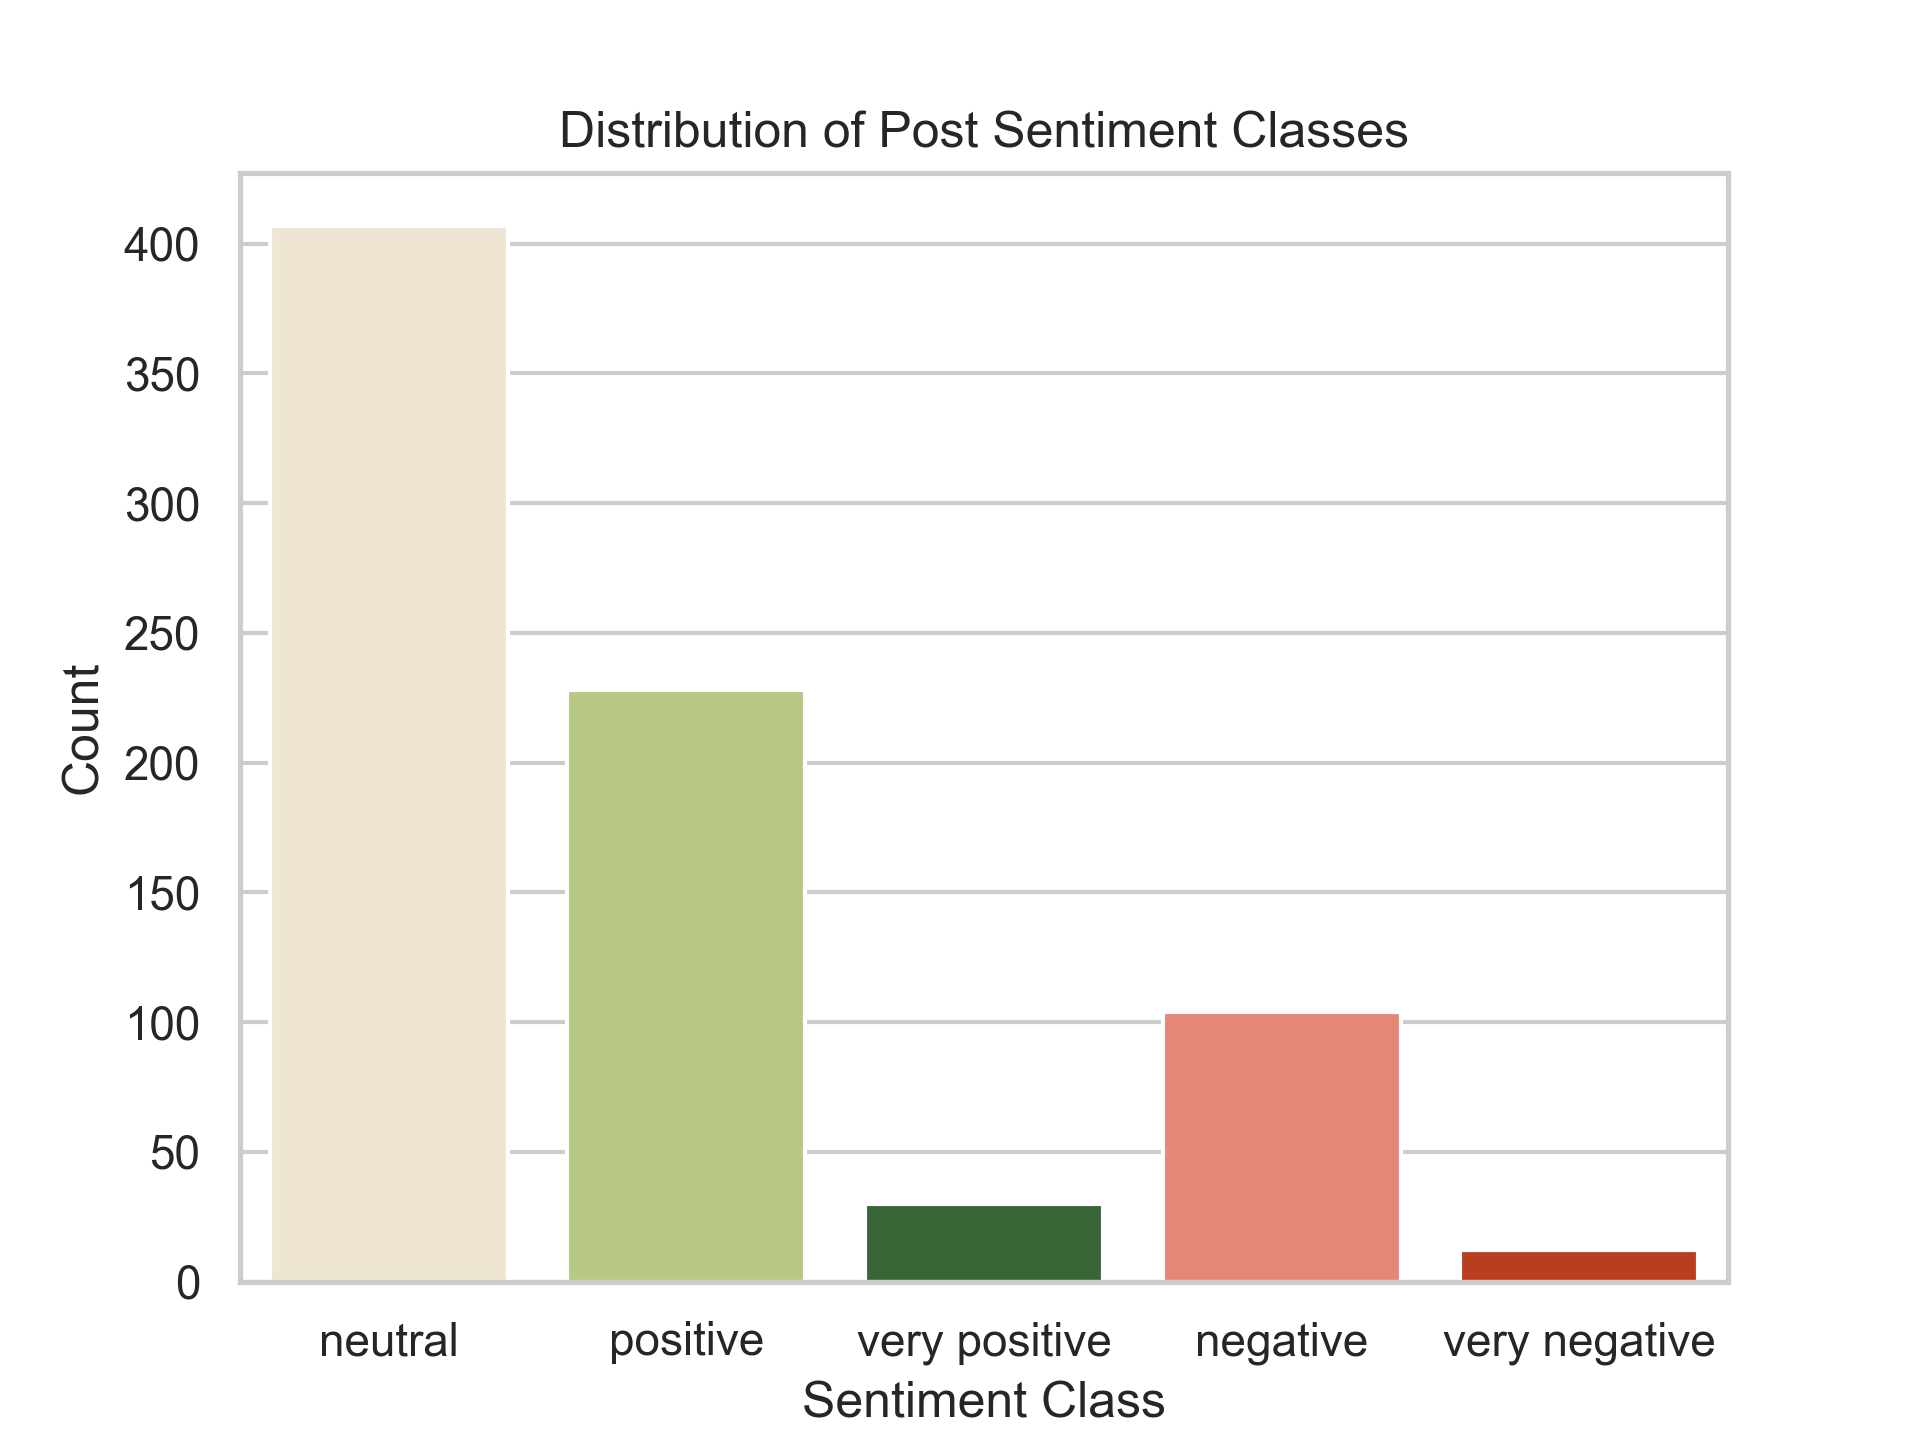

In [7]:
image_path = project_folder_path+ '/image/sentiment_class_countplot.png'
# Display the image in the Jupyter notebook
display(Image(filename=image_path))

#### Pie Chart - Percentage of Each Post Sentiment Class

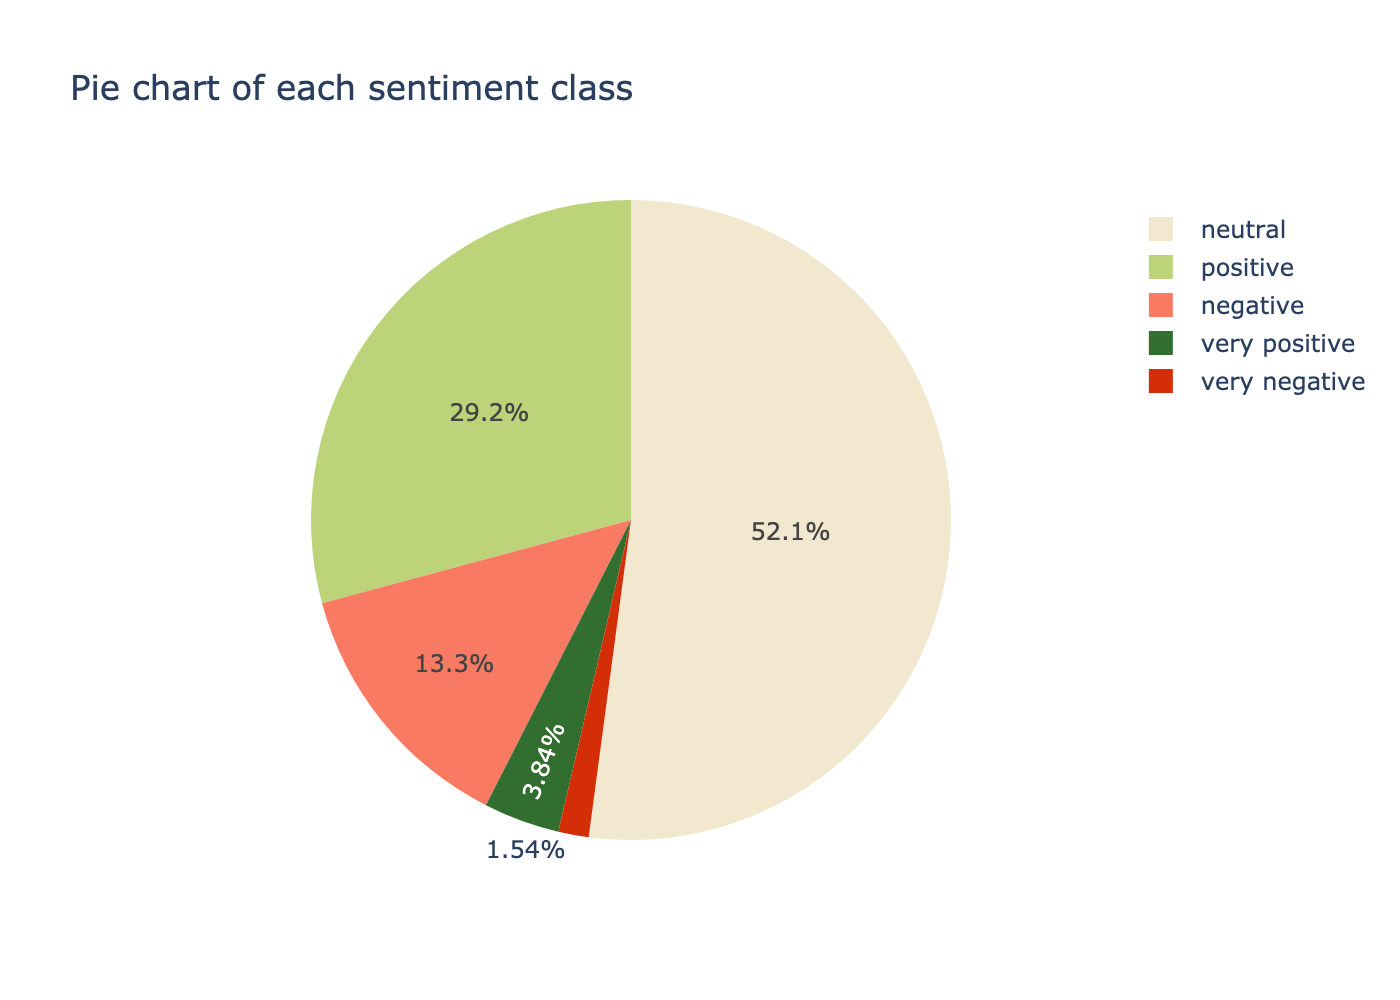

In [8]:
image_path = project_folder_path+ '/image/sentiment_class_pie_chart.png'
# Display the image in the Jupyter notebook
display(Image(filename=image_path))

### Data Transformation

In [9]:
gpt_sentiment.post_sentiment_class.unique()

array(['neutral', 'positive', 'very positive', 'negative',
       'very negative'], dtype=object)

In [10]:
# The following lines create the feature matrix X and target vector y
X = gpt_sentiment[gpt_sentiment.columns[:-1]].values
y = gpt_sentiment[gpt_sentiment.columns[-1]].values

# Splitting the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# Getting the list of feature column names except the last one
feature_col = gpt_sentiment.columns[:-1].tolist() # This is already a list, so it's correct
target_col = [gpt_sentiment.columns[-1]] # Make sure this is a list by enclosing it in square brackets

# Creating DataFrames training dataset
X_train_df = pd.DataFrame(X_train, columns=feature_col)
y_train_df = pd.DataFrame(y_train, columns=target_col)
train_data= pd.concat([X_train_df, y_train_df], axis=1)

# Creating DataFrames validation dataset
X_test_df = pd.DataFrame(X_test, columns=feature_col)
y_test_df = pd.DataFrame(y_test, columns=target_col)
val_data= pd.concat([X_test_df, y_test_df], axis=1)


In [11]:
# Text transformation
train_data["lower"]=train_data['title'].str.lower() #lowercase
train_data["lower"]=train_data['lower'].apply(lambda x: re.sub('[^A-Za-z0-9 ]+', ' ', x)) #regex

val_data["lower"]=val_data['title'].str.lower() #lowercase
val_data["lower"]=val_data['lower'].apply(lambda x: re.sub('[^A-Za-z0-9 ]+', ' ', x)) #regex


### Plotting features

- word cloud to see important words in each sentiment class on train_data dataset.

In [12]:
def create_wordcloud(df, sentiment_class):
    '''
    create a wordclod of data of sentiment_class
    '''
    # Combine all titles into a single string
    gpt = df[df['post_sentiment_class']==sentiment_class]
    text = ' '.join(gpt['lower'])


    # Create a WordCloud object
    wordcloud = WordCloud(width=400, height=400,
                          background_color='white',
                          min_font_size=10).generate(text)

    # Display the word cloud using matplotlib
    plt.figure(figsize=(8, 8), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

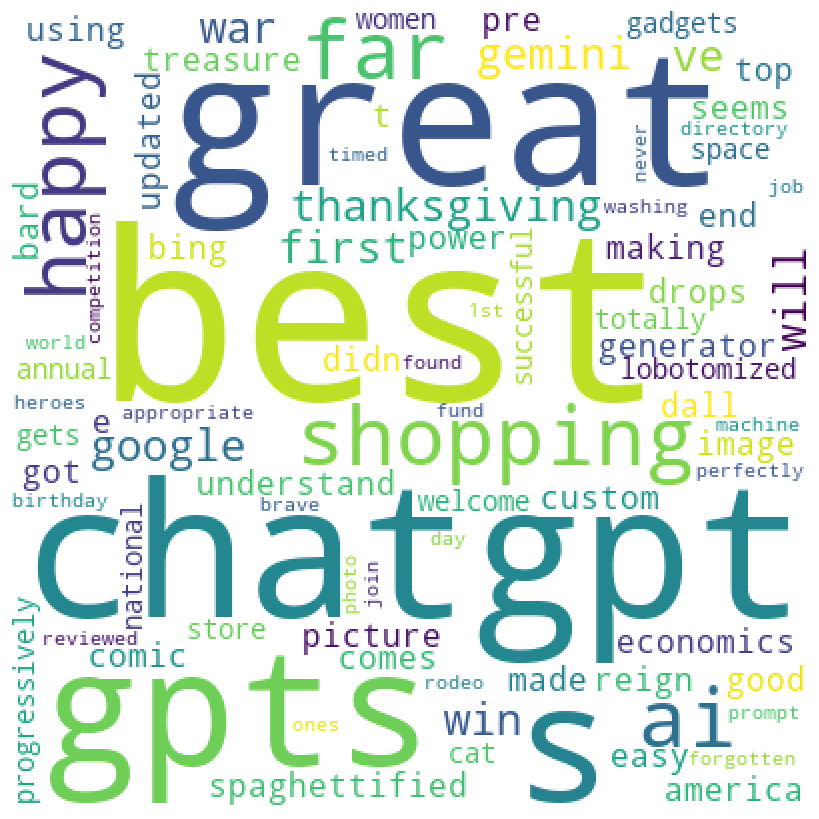

In [13]:
## Very Positive 
create_wordcloud(train_data, 'very positive')

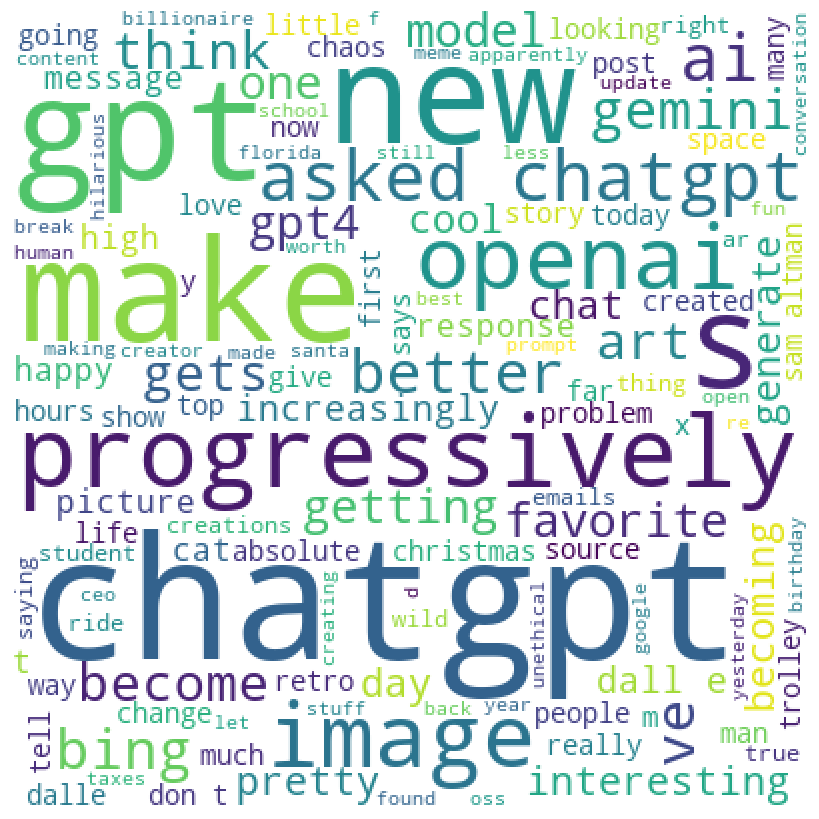

In [14]:
## Positive
create_wordcloud(train_data, 'positive')

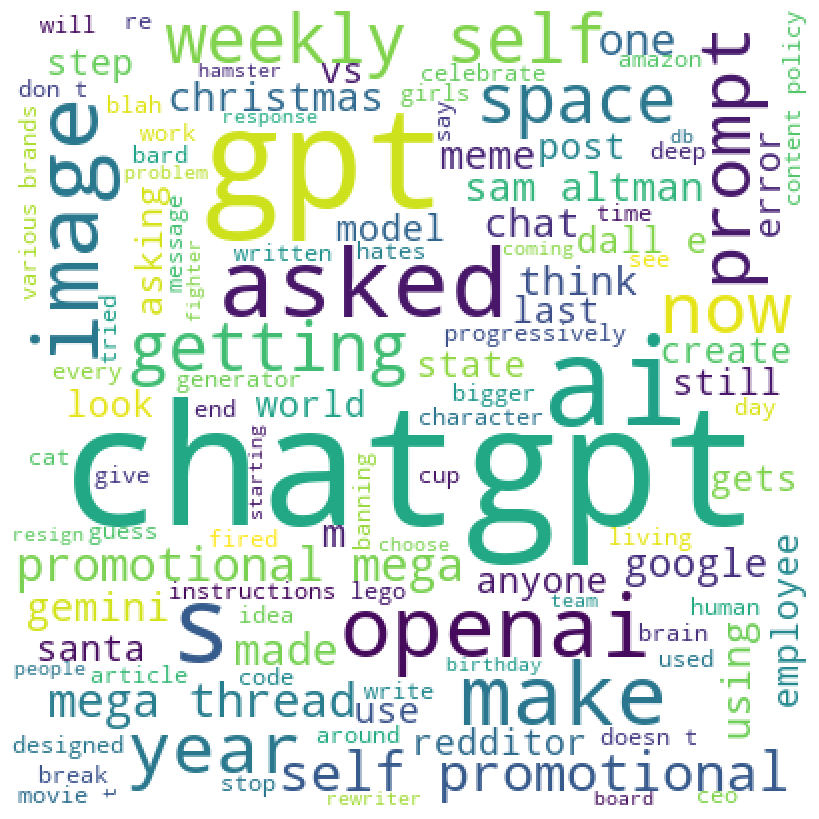

In [15]:
## neutral
create_wordcloud(train_data, 'neutral')

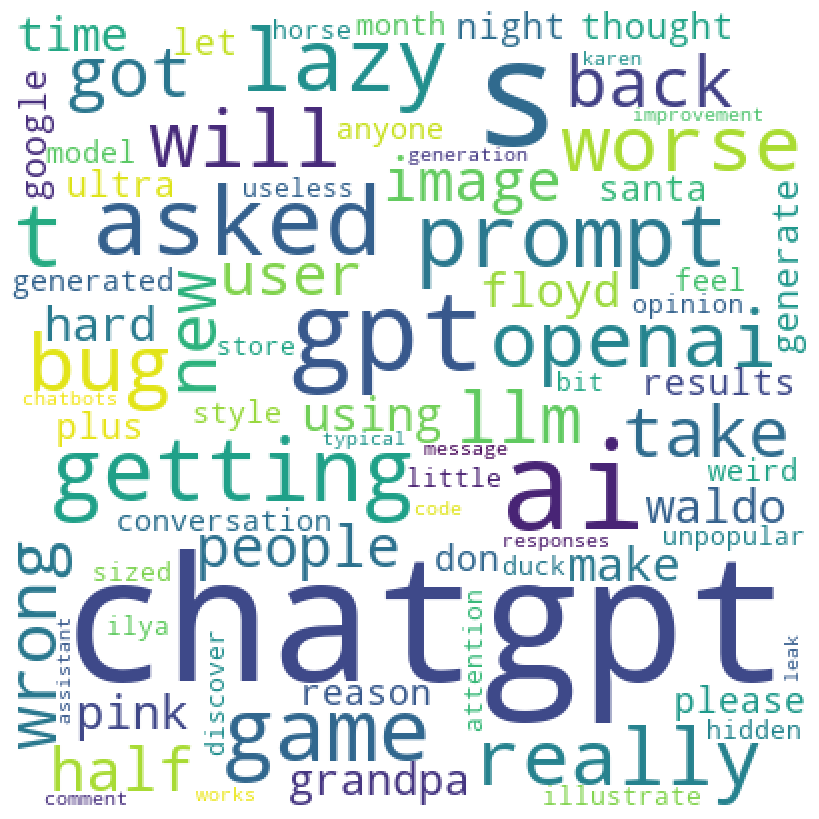

In [16]:
## negative
create_wordcloud(train_data, 'negative')

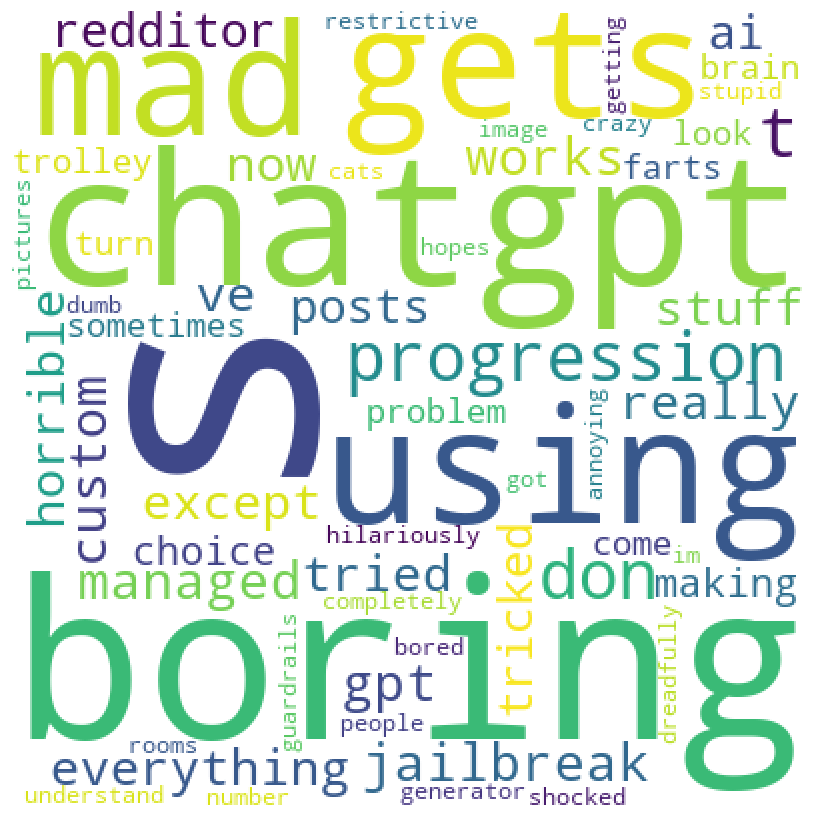

In [17]:
## very negative
create_wordcloud(train_data, 'very negative')


- **Very Positive**:
  - Contains words such as "excellent", "happy", "love", signifying strong positive emotions and success.

- **Positive**:
  - Includes less intense, but still positive words like "good", "enjoy", "like", indicative of approval or satisfaction.

- **Neutral**:
  - Features more factual or objective language without strong emotional connotations, e.g., "information", "announcement", "news".

- **Negative**:
  - Comprised of words with negative connotations such as "bad", "poor", "dislike", reflecting dissatisfaction or problems.

- **Very Negative**:
  - Filled with words that convey strong negative emotions or extreme dislike, like "terrible", "hate", "horrible", and possibly profanity.
